In [4]:
import os
import sys
import datetime
import shutil
import pickle
import json
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 시각화 관련 패키지
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['axes.unicode_minus'] = False

# 모델링 관련 패키지
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

In [1]:
data_path = r'C:\Users\Andrew\Desktop\data\data'

In [11]:
train_df = pd.read_csv(os.path.join(data_path, 'train.csv'))
test_df = pd.read_csv(os.path.join(data_path, 'test.csv'))
unlabel_df = pd.read_csv(os.path.join(data_path, 'unlabeled.csv'))

In [343]:
pd.read_csv(os.path.join(data_path, 'train.csv'))

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,84455,Female,disloyal Customer,23,Business travel,Eco,290,3,4,3,...,5,4,5,3,3,4,5,0,0.0,neutral or dissatisfied
1,90180,Male,Loyal Customer,61,Personal Travel,Eco,957,3,5,3,...,3,4,5,5,3,4,3,0,0.0,neutral or dissatisfied
2,33002,Male,Loyal Customer,43,Personal Travel,Eco,163,4,5,0,...,1,4,3,3,2,1,1,0,4.0,neutral or dissatisfied
3,124430,Female,Loyal Customer,28,Personal Travel,Eco,1262,2,4,2,...,4,3,5,3,4,4,4,0,2.0,neutral or dissatisfied
4,93970,Female,Loyal Customer,39,Business travel,Business,1218,4,4,4,...,4,4,4,4,4,4,4,0,0.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,26912,Male,Loyal Customer,32,Business travel,Business,1660,4,4,4,...,4,4,2,4,4,4,4,0,0.0,satisfied
9996,10438,Female,Loyal Customer,47,Business travel,Business,1717,5,5,5,...,4,4,4,4,3,4,5,10,4.0,satisfied
9997,124361,Male,disloyal Customer,45,Business travel,Business,808,4,4,4,...,1,5,5,4,5,5,1,0,0.0,neutral or dissatisfied
9998,38472,Male,Loyal Customer,35,Business travel,Eco,846,3,4,4,...,3,4,1,1,3,2,3,0,0.0,satisfied


In [279]:
print(train_df.shape)
print(test_df.shape)
print(unlabel_df.shape)

(10000, 26)
(20000, 26)
(99880, 23)


In [336]:
unlabel_df.columns

Index(['id', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes'],
      dtype='object')

In [280]:
train_df.head(3).T

,0,1,2
Gender,0.0,1.0,1.0
Customer Type,0.0,1.0,1.0
Age,23.0,61.0,43.0
Flight Distance,290.0,957.0,163.0
Inflight wifi service,3.0,3.0,4.0
Departure/Arrival time convenient,4.0,5.0,5.0
Ease of Online booking,3.0,3.0,0.0
Gate location,3.0,3.0,5.0
Food and drink,5.0,3.0,1.0
Online boarding,3.0,3.0,0.0


# EDA 

### Null Value Check

In [32]:
train_df.isnull().sum()

id                                    0
Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             23
satisfaction                          0
dtype: int64

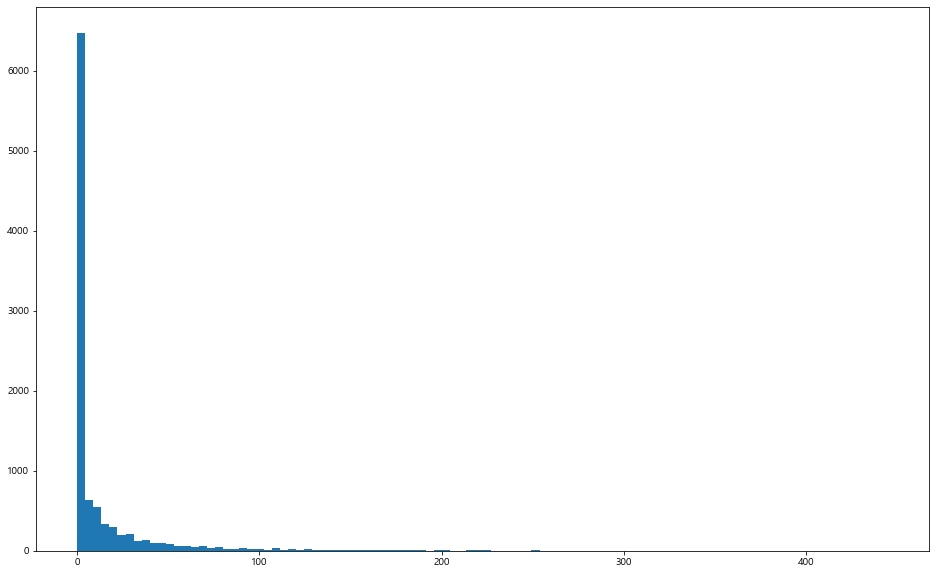

In [337]:
plt.figure(figsize = (16, 10))

plt.hist(train_df['Arrival Delay in Minutes'], bins = 100)
plt.show()

In [41]:
train_df['Arrival Delay in Minutes'].fillna(0, inplace = True)

### 각 특성 분포 확인

### Label Distribution

[None, None]

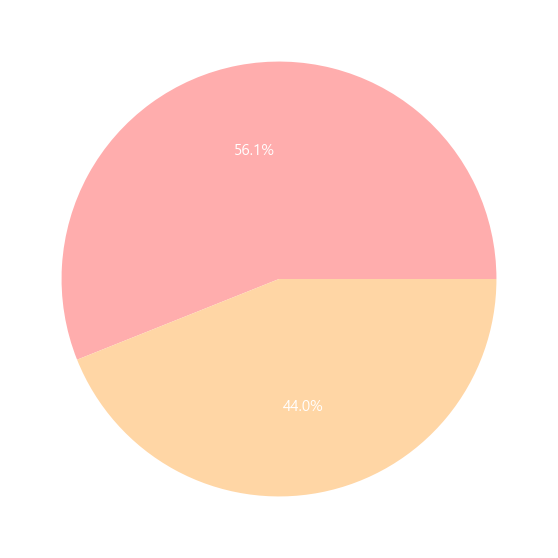

In [29]:
fig, ax = plt.subplots(1, 1, figsize = (16, 10))

patches, texts, autotexts = ax.pie(train_df.groupby('satisfaction').size(),
                                   labels = train_df.groupby('satisfaction').size().index,
                                   labeldistance = 1.1,
                                   autopct = '%.1f%%',
                                   colors = ['#ffadad', '#ffd6a5'])

[text.set_color('w') for text in texts]
[text.set_size(20) for text in texts]
[autotext.set_color('w') for autotext in autotexts]
[autotext.set_size(15) for autotext in autotexts]

### Gender Distribution

- Label Encoding 필요

[None, None]

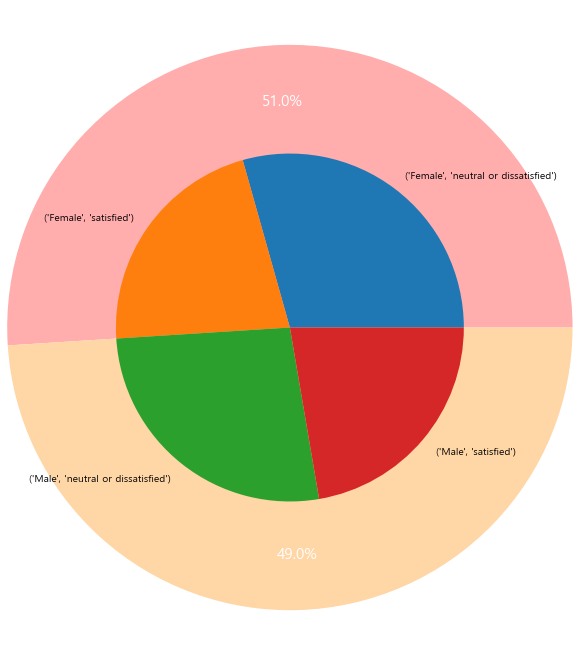

In [77]:
fig, ax = plt.subplots(1, 1, figsize = (16, 10))

patches, texts, autotexts = ax.pie(train_df.groupby('Gender').size(),
                                   labels = train_df.groupby('Gender').size().index,
                                   labeldistance = 1.1,
                                   autopct = '%.1f%%',
                                   colors = ['#ffadad', '#ffd6a5'],
                                   pctdistance = 0.8,
                                   radius = 1.3)

ax.pie(train_df.groupby(['Gender', 'satisfaction']).size().values,
       labels = train_df.groupby(['Gender', 'satisfaction']).size().index,
       radius = 0.8)


[text.set_color('w') for text in texts]
[text.set_size(20) for text in texts]
[autotext.set_color('w') for autotext in autotexts]
[autotext.set_size(15) for autotext in autotexts]

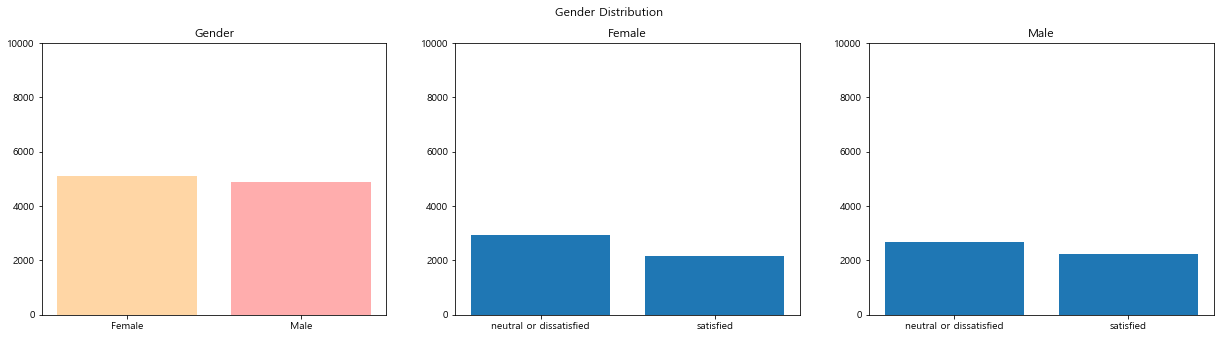

In [141]:
fig, axes = plt.subplots(1, 3, figsize = (21, 5))

axes[0].bar(train_df.groupby('Gender').size().index,
            train_df.groupby('Gender').size().values,
            color = ['#ffd6a5', '#ffadad'])
axes[0].set_title('Gender')

axes[1].bar(train_df.groupby(['Gender', 'satisfaction']).size().loc['Female'].index,
            train_df.groupby(['Gender', 'satisfaction']).size().loc['Female'])
axes[1].set_title('Female')

axes[2].bar(train_df.groupby(['Gender', 'satisfaction']).size().loc['Male'].index,
            train_df.groupby(['Gender', 'satisfaction']).size().loc['Male'])
axes[2].set_title('Male')

axes[0].set_ylim(0, len(train_df))
axes[1].set_ylim(0, len(train_df))
axes[2].set_ylim(0, len(train_df))

fig.suptitle('Gender Distribution')
plt.show()

In [133]:
# Female - 0
# Male - 1

train_df['Gender'].replace('Female', 0, inplace = True)
train_df['Gender'].replace('Male', 1, inplace = True)

train_df['Gender'].replace(0, 'Female', inplace = True)
train_df['Gender'].replace(1, 'Male', inplace = True)

### Customer Type Distribution

Loyal customer 에서는 두 만족도의 비율이 비슷하게 나타나는 반면,

disloyal customer층에서는 불만족이 상대적으로 많이 나타나는 것을 확인할 수 있다.

In [157]:
print(train_df['Customer Type'].unique())

['disloyal Customer' 'Loyal Customer']


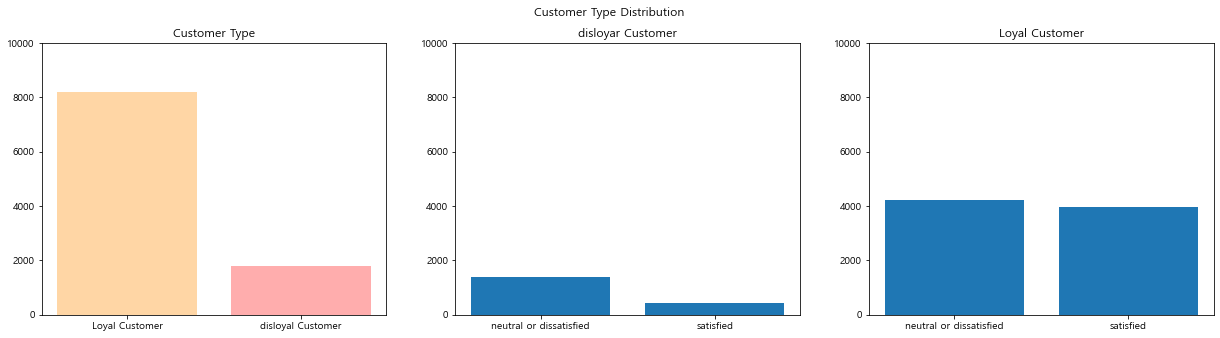

In [143]:
fig, axes = plt.subplots(1, 3, figsize = (21, 5))

axes[0].bar(train_df.groupby('Customer Type').size().index,
            train_df.groupby('Customer Type').size().values,
            color = ['#ffd6a5', '#ffadad'])
axes[0].set_title('Customer Type')

axes[1].bar(train_df.groupby(['Customer Type', 'satisfaction']).size().loc['disloyal Customer'].index,
            train_df.groupby(['Customer Type', 'satisfaction']).size().loc['disloyal Customer'])
axes[1].set_title('disloyar Customer')

axes[2].bar(train_df.groupby(['Customer Type', 'satisfaction']).size().loc['Loyal Customer'].index,
            train_df.groupby(['Customer Type', 'satisfaction']).size().loc['Loyal Customer'])
axes[2].set_title('Loyal Customer')

axes[0].set_ylim(0, len(train_df))
axes[1].set_ylim(0, len(train_df))
axes[2].set_ylim(0, len(train_df))

fig.suptitle('Customer Type Distribution')
plt.show()

### Age Distribution

상대적으로 젊은 층(20~30대)에서 불만족 경향이 더 강하게 나타나고,

40~50대에서는 만족하는 경향이 높다.

나이대를 그룹핑해서 처리하면 어떨까?

Text(0.5, 1.0, 'satisfied')

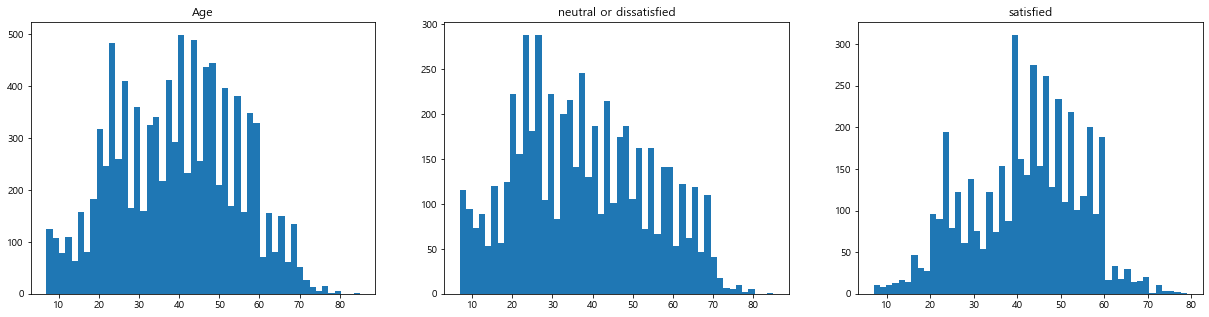

In [153]:
fig, axes = plt.subplots(1, 3, figsize = (21, 5))

axes[0].hist(train_df['Age'], bins = 50)
axes[0].set_title('Age')

axes[1].hist(train_df.loc[train_df['satisfaction'] == 'neutral or dissatisfied', 'Age'], bins = 50)
axes[1].set_title('neutral or dissatisfied')

axes[2].hist(train_df.loc[train_df['satisfaction'] == 'satisfied', 'Age'], bins = 50)
axes[2].set_title('satisfied')

### Type of Travel

개인 여행의 경우 만족하지 못하는 비율이 압도적으로 높게 나타나며,

반대로 비즈니스 여행의 경우 만족도가 더 높은 비율로 나타난다.

In [158]:
print(train_df['Type of Travel'].unique())

['Business travel' 'Personal Travel']


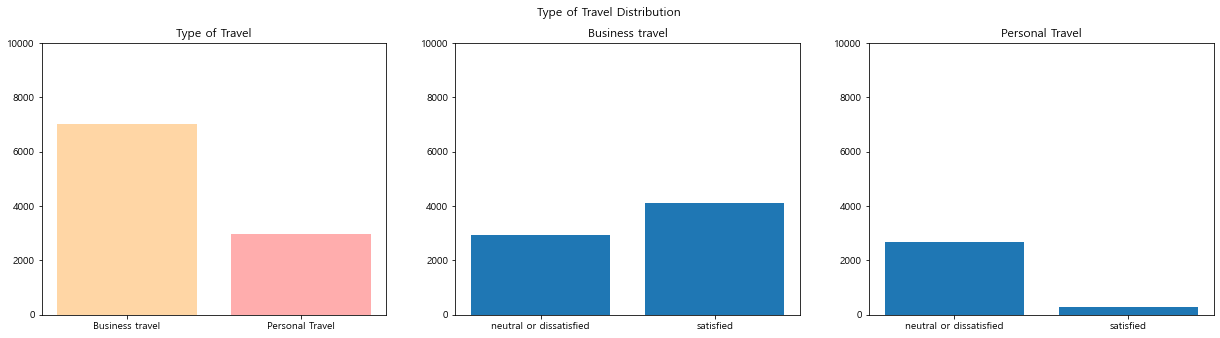

In [159]:
fig, axes = plt.subplots(1, 3, figsize = (21, 5))

axes[0].bar(train_df.groupby('Type of Travel').size().index,
            train_df.groupby('Type of Travel').size().values,
            color = ['#ffd6a5', '#ffadad'])
axes[0].set_title('Type of Travel')

axes[1].bar(train_df.groupby(['Type of Travel', 'satisfaction']).size().loc['Business travel'].index,
            train_df.groupby(['Type of Travel', 'satisfaction']).size().loc['Business travel'])
axes[1].set_title('Business travel')

axes[2].bar(train_df.groupby(['Type of Travel', 'satisfaction']).size().loc['Personal Travel'].index,
            train_df.groupby(['Type of Travel', 'satisfaction']).size().loc['Personal Travel'])
axes[2].set_title('Personal Travel')

axes[0].set_ylim(0, len(train_df))
axes[1].set_ylim(0, len(train_df))
axes[2].set_ylim(0, len(train_df))

fig.suptitle('Type of Travel Distribution')
plt.show()

### Class

In [160]:
print(train_df['Class'].unique())

['Eco' 'Business' 'Eco Plus']


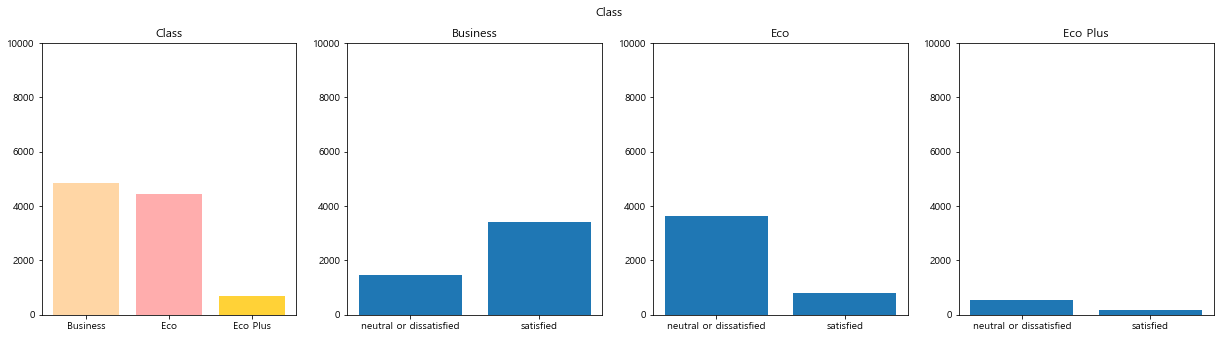

In [166]:
fig, axes = plt.subplots(1, 4, figsize = (21, 5))

axes[0].bar(train_df.groupby('Class').size().index,
            train_df.groupby('Class').size().values,
            color = ['#ffd6a5', '#ffadad', '#ffd237'])
axes[0].set_title('Class')

axes[1].bar(train_df.groupby(['Class', 'satisfaction']).size().loc['Business'].index,
            train_df.groupby(['Class', 'satisfaction']).size().loc['Business'])
axes[1].set_title('Business')

axes[2].bar(train_df.groupby(['Class', 'satisfaction']).size().loc['Eco'].index,
            train_df.groupby(['Class', 'satisfaction']).size().loc['Eco'])
axes[2].set_title('Eco')

axes[3].bar(train_df.groupby(['Class', 'satisfaction']).size().loc['Eco Plus'].index,
            train_df.groupby(['Class', 'satisfaction']).size().loc['Eco Plus'])
axes[3].set_title('Eco Plus')

axes[0].set_ylim(0, len(train_df))
axes[1].set_ylim(0, len(train_df))
axes[2].set_ylim(0, len(train_df))
axes[3].set_ylim(0, len(train_df))

fig.suptitle('Class')
plt.show()

### Flight Distance

비행 거리에 따라서는 만족도의 분포에 뚜렷한 차이가 보이지 않는다.

(0.0, 1000.0)

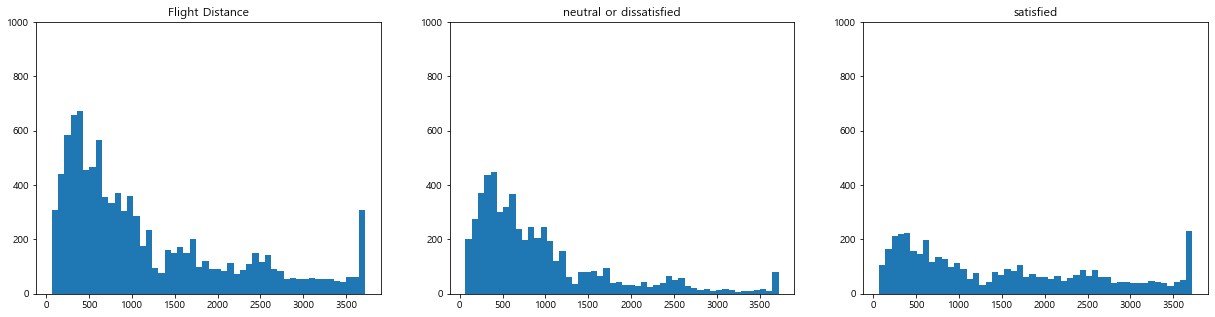

In [340]:
fig, axes = plt.subplots(1, 3, figsize = (21, 5))

axes[0].hist(train_df['Flight Distance'], bins = 50)
axes[0].set_title('Flight Distance')

axes[1].hist(train_df.loc[train_df['satisfaction'] == 'neutral or dissatisfied', 'Flight Distance'], bins = 50)
axes[1].set_title('neutral or dissatisfied')

axes[2].hist(train_df.loc[train_df['satisfaction'] == 'satisfied', 'Flight Distance'], bins = 50)
axes[2].set_title('satisfied')

axes[0].set_ylim(0, 1000)
axes[1].set_ylim(0, 1000)
axes[2].set_ylim(0, 1000)

# Oulier Check

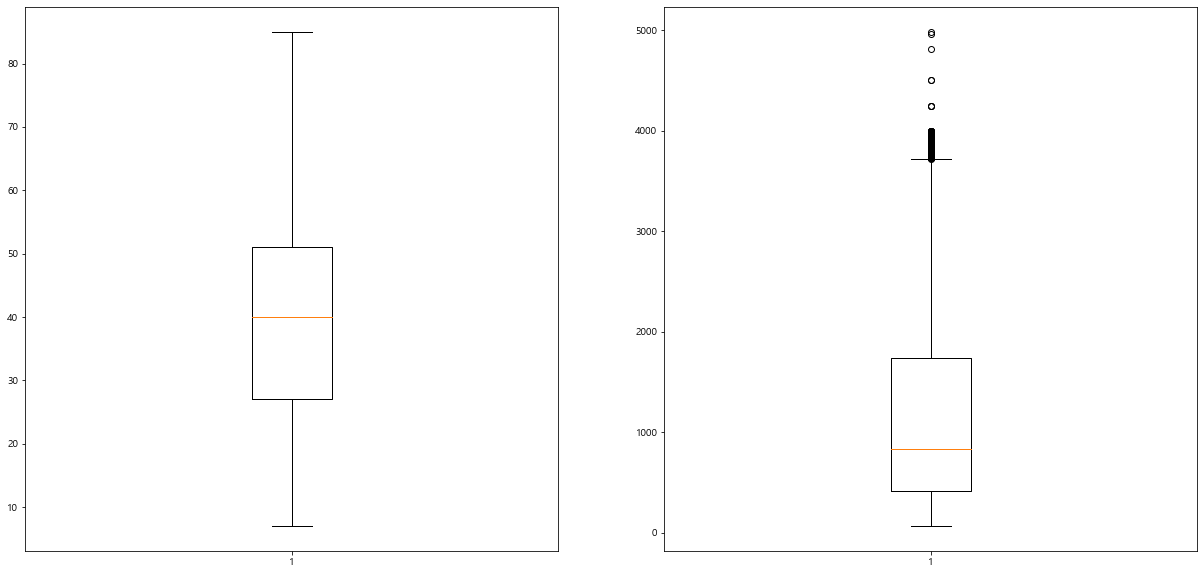

In [285]:
check_columns = ['Age', 'Flight Distance']

fig, axes = plt.subplots(1, 2, figsize = (21, 10))

for i, c in enumerate(check_columns):
    axes[i].boxplot(train_df[c])

In [290]:
q1 = train_df['Flight Distance'].quantile(0.25)
q3 = train_df['Flight Distance'].quantile(0.75)

iqr = q3-q1

In [291]:
train_df.loc[train_df['Flight Distance'] > (q3 + 1.5 * iqr), 'Flight Distance'] = (q3 + 1.5 * iqr)

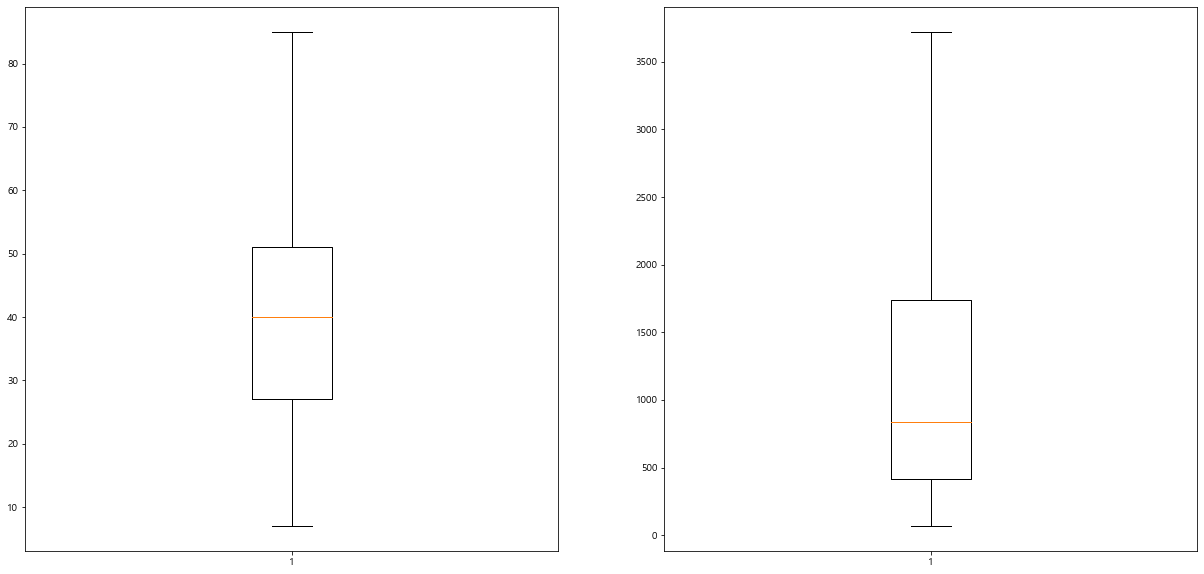

In [292]:
check_columns = ['Age', 'Flight Distance']

fig, axes = plt.subplots(1, 2, figsize = (21, 10))

for i, c in enumerate(check_columns):
    axes[i].boxplot(train_df[c])

### Score Data

'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness'
       
위 컬럼들에 대해서는 고객들이 응답한 스코어가 기록되어있다. (1 ~ 5)

0 이 있는 경우, 없는 경우가 있는데, 

In [171]:
columns = ['Inflight wifi service', 'Departure/Arrival time convenient',
           'Ease of Online booking', 'Gate location', 'Food and drink',
           'Online boarding', 'Seat comfort', 'Inflight entertainment',
           'On-board service', 'Leg room service', 'Baggage handling',
           'Checkin service', 'Inflight service', 'Cleanliness']

In [173]:
for c in columns:
    print(sorted(train_df[c].unique()))

[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]


Inflight wifi service
Departure/Arrival time convenient
Ease of Online booking
Gate location
Food and drink
Online boarding
Seat comfort
Inflight entertainment
On-board service
Leg room service
Baggage handling
Checkin service
Inflight service
Cleanliness


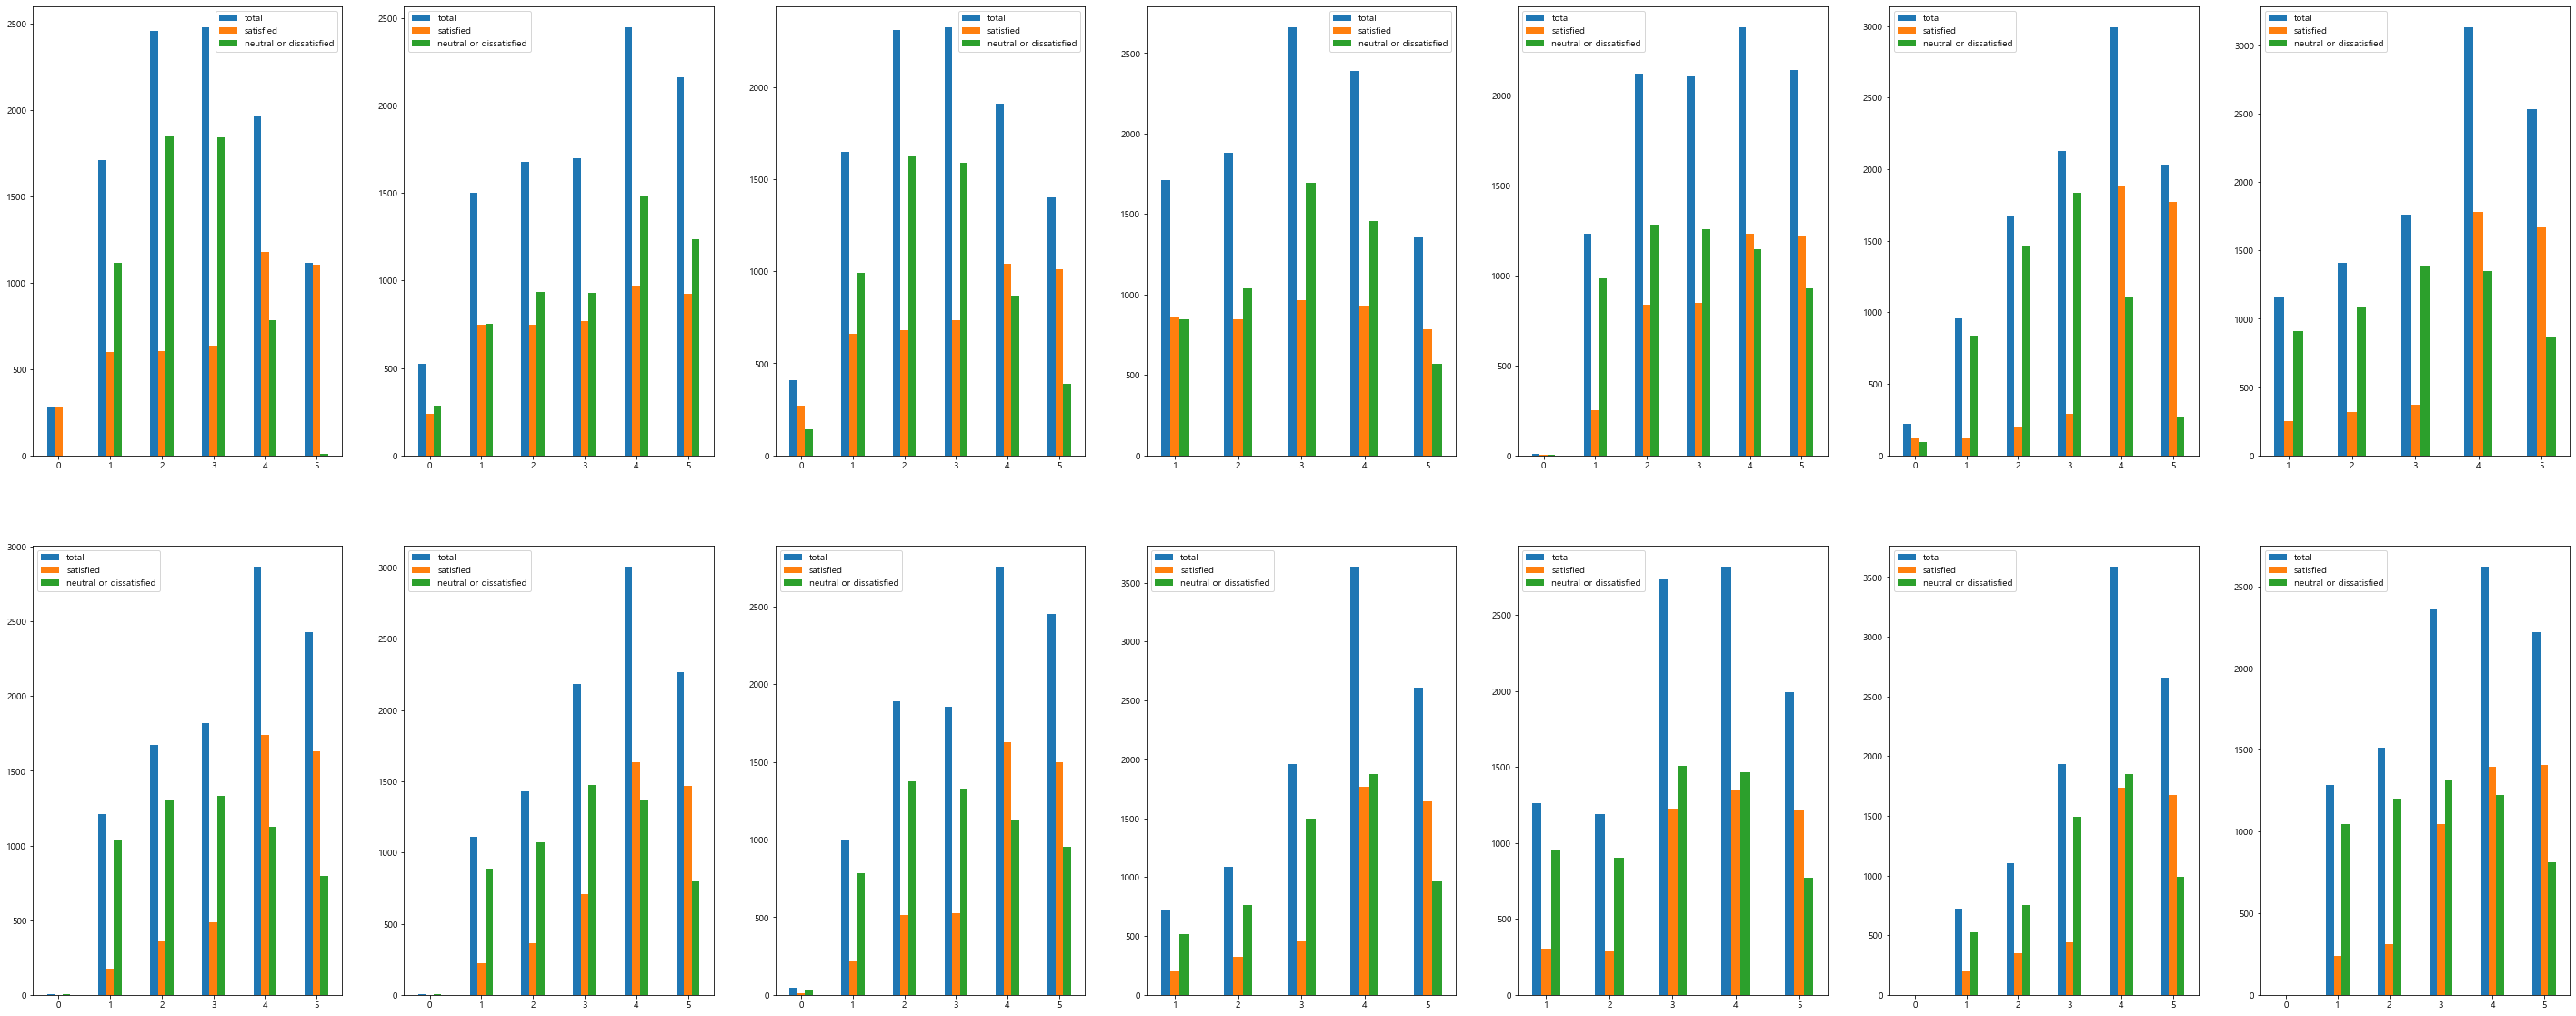

In [333]:
fig, axes = plt.subplots(2, 7, figsize = (50, 20))

for i, c in enumerate(columns):
    print(c)
    axes[0 if i < 7 else 1][i%7].bar(train_df.groupby(c).size().index-0.15,
            train_df.groupby(c).size(),
            width = 0.15,
            label = 'total')
    axes[0 if i < 7 else 1][i%7].bar(train_df.loc[train_df['satisfaction'] == 1].groupby(c).size().index,
            train_df.loc[train_df['satisfaction'] == 1].groupby(c).size(),
            width = 0.15,
            label = 'satisfied')
    axes[0 if i < 7 else 1][i%7].bar(train_df.loc[train_df['satisfaction'] == 0].groupby(c).size().index+0.15,
            train_df.loc[train_df['satisfaction'] == 0].groupby(c).size(),
            width = 0.15,
            label = 'neutral or dissatisfied')

    axes[0 if i < 7 else 1][i%7].legend()

plt.show()

# Label & Feature Encoding

In [194]:
# satisfaction
train_df['satisfaction'].replace('neutral or dissatisfied', 0, inplace = True)
train_df['satisfaction'].replace('satisfied', 1, inplace = True)

In [214]:
# Gender
train_df['Gender'].replace('Female', 0, inplace = True)
train_df['Gender'].replace('Male', 1, inplace = True)

In [196]:
# Customer Type
train_df['Customer Type'].replace('disloyal Customer', 0, inplace = True)
train_df['Customer Type'].replace('Loyal Customer', 1, inplace = True)

In [198]:
# Type of Travel
train_df = pd.get_dummies(train_df, columns = ['Type of Travel'])

# Class
train_df = pd.get_dummies(train_df, columns = ['Class'])

In [202]:
train_df.drop(['id'], axis = 1, inplace = True)

In [272]:
def feature_encoding(input_df):
    input_df['satisfaction'].replace('neutral or dissatisfied', 0, inplace = True)
    input_df['satisfaction'].replace('satisfied', 1, inplace = True)
    
    input_df['Gender'].replace('Female', 0, inplace = True)
    input_df['Gender'].replace('Male', 1, inplace = True)
    
    input_df['Customer Type'].replace('disloyal Customer', 0, inplace = True)
    input_df['Customer Type'].replace('Loyal Customer', 1, inplace = True)
    
    input_df = pd.get_dummies(input_df, columns = ['Type of Travel'])

    input_df = pd.get_dummies(input_df, columns = ['Class'])
    
    input_df.drop(['id'], axis = 1, inplace = True)
    
    return input_df

# Modeling

In [208]:
train_df.shape

(10000, 26)

In [215]:
y = train_df['satisfaction']
X = train_df.drop(['satisfaction'], axis = 1)

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 311)

In [242]:
X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

In [345]:
X_train

,Gender,Customer Type,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,...,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
5180,1,1,30,522,5,5,5,5,4,5,...,3,5,4,0,0.0,1,0,1,0,0
5804,0,1,65,978,0,4,0,3,5,5,...,3,1,3,0,0.0,0,1,0,1,0
8778,0,0,57,248,4,4,4,3,2,4,...,3,5,2,0,0.0,1,0,1,0,0
5081,1,1,8,529,3,4,3,1,1,3,...,3,4,1,9,5.0,0,1,1,0,0
6729,0,1,57,130,1,1,4,1,2,1,...,4,5,2,0,22.0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4461,0,1,57,3634,1,3,2,3,5,2,...,1,1,2,3,0.0,1,0,1,0,0
1577,1,1,11,3338,5,5,5,5,4,4,...,3,5,4,0,0.0,1,0,1,0,0
9190,1,0,22,599,0,0,0,1,5,0,...,3,4,5,6,0.0,1,0,0,1,0
5213,0,1,27,2608,3,3,3,3,3,3,...,5,4,3,0,44.0,1,0,1,0,0


In [347]:
X_train_scaled

array([[ 1.0166384 ,  0.46752903, -0.62349301, ...,  1.03485715,
        -0.89566049, -0.27854301],
       [-0.98363391,  0.46752903,  1.69272577, ..., -0.96631694,
         1.11649449, -0.27854301],
       [-0.98363391, -2.1389046 ,  1.16330434, ...,  1.03485715,
        -0.89566049, -0.27854301],
       ...,
       [ 1.0166384 , -2.1389046 , -1.15291444, ..., -0.96631694,
         1.11649449, -0.27854301],
       [-0.98363391,  0.46752903, -0.82202604, ...,  1.03485715,
        -0.89566049, -0.27854301],
       [-0.98363391,  0.46752903,  0.43534986, ...,  1.03485715,
        -0.89566049, -0.27854301]])

In [247]:
kfold = StratifiedKFold(n_splits = 10)

In [257]:
parameters = {'min_child_weight': [1, 5, 10],
              'gamma': [0.5, 1, 1.5, 2, 5],
              'max_depth': [3, 4, 5],
              'subsample': [0.6, 0.8, 1.0]}

In [258]:
xgb_model = xgb.XGBClassifier(learning_rate = 0.2,
                              n_estimators = 50,
                              objective = 'binary:logistic')

In [259]:
xgb_grid = GridSearchCV(xgb_model,
                        parameters,
                        cv = 2,
                        n_jobs = 1,
                        verbose = True)

In [260]:
xgb_grid.fit(X_train_scaled, y_train)

Fitting 2 folds for each of 135 candidates, totalling 270 fits
[11:49:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:49:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:49:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:49:

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[11:49:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:49:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:49:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:49:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   12.5s finished


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.2, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_co...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, use_label_encoder=True,
                                     validate_parameters=N

In [262]:
xgb_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=8,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='exact',
              use_label_encoder=True, validate_parameters=1, verbosity=None)

In [263]:
xgb_grid.best_score_

0.9455

In [267]:
accuracy_score(y_test, xgb_grid.predict(X_test_scaled))

0.95

# Test Data에 적용해보기

In [273]:
test_df = feature_encoding(test_df)

In [276]:
test_df_X = StandardScaler().fit_transform(test_df.drop(['satisfaction'], axis = 1))
test_df_y = test_df['satisfaction']

In [278]:
accuracy_score(test_df_y, xgb_grid.predict(test_df_X))

0.9519